In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules

In [124]:
import numpy as np
import pandas as pd

#models
from sklearn. neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#for CV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV #CV?

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Load the data

In [125]:
df = pd.read_csv('./data/sleepdata.csv',delimiter=";")
df

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0
...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91%,9:08,NaN,NaN,NaN,56
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81%,7:11,NaN,NaN,NaN,64
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71%,8:56,NaN,NaN,NaN,3316
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80%,9:13,NaN,NaN,NaN,6555


We display the  data

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Start             887 non-null    object 
 1   End               887 non-null    object 
 2   Sleep quality     887 non-null    object 
 3   Time in bed       887 non-null    object 
 4   Wake up           246 non-null    object 
 5   Sleep Notes       652 non-null    object 
 6   Heart rate        162 non-null    float64
 7   Activity (steps)  887 non-null    int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 55.6+ KB


[Text(0.5, 1.0, 'Values of the dataset that are null')]

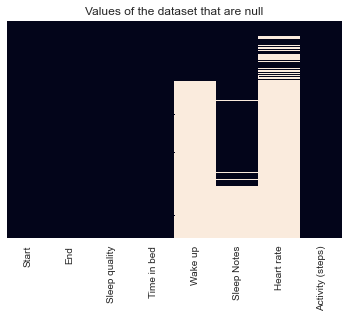

In [127]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False).set(title='Values of the dataset that are null')

As we can see in the graph the columns "heart rate" and "Wake up" are mostly null. However, the wake up column is not important for predicting the result of sleep quality. Because the mood when you wake up is a consequence of the sleep quality and not the opposite and the heart rate is 86% null values so it is not possible to extract information from that column.

In [128]:
#Drop the columns 'Wake up' and 'Heart rate'
df_cleaned=df.drop(columns=['Wake up','Heart rate'])

Another colum with lots of nulls is the column sleep notes but in this case null means that there are no extra notes for that nigth.

In [129]:
df_cleaned['Sleep Notes'].fillna(value = '', inplace = True)

[Text(0.5, 1.0, 'Values of the dataset that are null')]

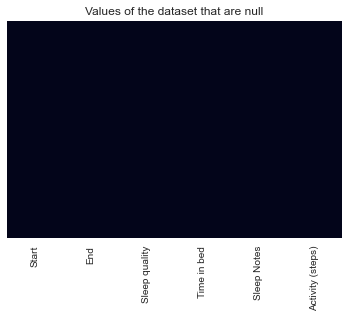

In [130]:
sns.heatmap(df_cleaned.isnull(),yticklabels=False,cbar=False).set(title='Values of the dataset that are null')

Transforming the 'Start' and 'End' columns to datetime type and the 'Time in bed' to seconds.

In [131]:
df_cleaned['Start'] = pd.to_datetime(df_cleaned['Start'])
df_cleaned['End'] = pd.to_datetime(df_cleaned['End'])
df_cleaned['Time in bed'] = (df_cleaned['End'] - df_cleaned['Start']).astype('timedelta64[s]')
df_cleaned['Sleep quality'] = df_cleaned['Sleep quality'].apply(lambda x: np.nan if x in ['-'] else x[:-1]).astype(int)
df_cleaned['Start time'] = pd.Series([val.time() for val in df_cleaned['Start']])
df_cleaned['End time'] = pd.Series([val.time() for val in df_cleaned['End']])
df_cleaned['Start time in second'] = df_cleaned['Start'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)
df_cleaned['End time in second'] = df_cleaned['End'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)

In [132]:
df_cleaned

,Start,End,Sleep quality,Time in bed,Sleep Notes,Activity (steps),Start time,End time,Start time in second,End time in second
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100,30744.0,,0,22:57:49,07:30:13,82669,27013
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3,964.0,Stressful day,0,21:17:50,21:33:54,76670,77634
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98,30642.0,,0,22:42:49,07:13:31,81769,26011
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65,27120.0,,0,22:31:01,06:03:01,81061,21781
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72,24265.0,Drank coffee:Drank tea,0,22:12:10,04:56:35,79930,17795
...,...,...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91,32881.0,,56,21:54:14,07:02:15,78854,25335
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81,25894.0,,64,23:49:19,07:00:53,85759,25253
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71,32207.0,,3316,21:24:05,06:20:52,77045,22852
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80,33239.0,,6555,21:36:32,06:50:31,77792,24631


In [133]:
sleep_notes_values=np.unique(df_cleaned['Sleep Notes'].apply(lambda x: x.split(':')).sum())
sleep_notes_values=sleep_notes_values[1:]
print("All the different values for the Sleep notes: "+str(sleep_notes_values))

All the different values for the Sleep notes: ['Ate late' 'Drank coffee' 'Drank tea' 'Stressful day' 'Worked out']


Transform the categorical of 'Sleep notes' into dummy/indicator variables.

In [134]:
for v in sleep_notes_values:
    df_cleaned[v] = df_cleaned['Sleep Notes'].apply(lambda x: v in x).astype(int)

In [135]:
df_cleaned

,Start,End,Sleep quality,Time in bed,Sleep Notes,Activity (steps),Start time,End time,Start time in second,End time in second,Ate late,Drank coffee,Drank tea,Stressful day,Worked out
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100,30744.0,,0,22:57:49,07:30:13,82669,27013,0,0,0,0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3,964.0,Stressful day,0,21:17:50,21:33:54,76670,77634,0,0,0,1,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98,30642.0,,0,22:42:49,07:13:31,81769,26011,0,0,0,0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65,27120.0,,0,22:31:01,06:03:01,81061,21781,0,0,0,0,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72,24265.0,Drank coffee:Drank tea,0,22:12:10,04:56:35,79930,17795,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91,32881.0,,56,21:54:14,07:02:15,78854,25335,0,0,0,0,0
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81,25894.0,,64,23:49:19,07:00:53,85759,25253,0,0,0,0,0
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71,32207.0,,3316,21:24:05,06:20:52,77045,22852,0,0,0,0,0
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80,33239.0,,6555,21:36:32,06:50:31,77792,24631,0,0,0,0,0


In [136]:
tc_df = df_cleaned[['Sleep quality', 'Time in bed', 'Drank tea', 'Drank coffee', 'Worked out', 'Ate late', 'Stressful day']].groupby(['Drank tea', 'Drank coffee']).mean()
tc_df

Sleep quality   Time in bed  Worked out  Ate late  \
Drank tea Drank coffee                                                      
0         0                 70.527426  26425.966245    0.004219  0.000000   
          1                 74.850515  28125.417526    0.561856  0.025773   
1         0                 77.373016  28720.865079    0.531746  0.000000   
          1                 77.112121  27559.172727    0.566667  0.048485   

                        Stressful day  
Drank tea Drank coffee                 
0         0                  0.004219  
          1                  0.118557  
1         0                  0.047619  
          1                  0.084848

In [137]:
wo_df = df_cleaned[['Sleep quality', 'Time in bed', 'Drank tea', 'Drank coffee', 'Worked out', 'Ate late', 'Stressful day']].groupby(['Worked out']).mean()
wo_df

,Sleep quality,Time in bed,Drank tea,Drank coffee,Ate late,Stressful day
Worked out,,,,,,
0,74.388145,27526.118547,0.386233,0.435946,0.015296,0.047801
1,75.623626,27572.750000,0.697802,0.813187,0.035714,0.090659


In [138]:
st_df = df_cleaned[['Sleep quality', 'Time in bed', 'Drank tea', 'Drank coffee', 'Worked out', 'Ate late', 'Stressful day']].groupby(['Ate late', 'Stressful day']).mean()
st_df

Sleep quality   Time in bed  Drank tea  Drank coffee  \
Ate late Stressful day                                                         
0        0                  74.619283  27531.244747   0.503090      0.559951   
         1                  77.982456  27827.754386   0.578947      0.877193   
1        0                  77.400000  27316.300000   0.750000      1.000000   
         1                  72.000000  27356.000000   1.000000      1.000000   

                        Worked out  
Ate late Stressful day              
0        0                0.393078  
         1                0.578947  
1        0                0.650000  
         1                0.000000

In [139]:
df_cleaned['Day of week'] = [x.weekday() for x in df_cleaned['Start']]
df_cleaned_days_week=df_cleaned.copy()
df_cleaned_days_week['Day of week'] = df_cleaned['Day of week'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

[Text(0.5, 1.0, 'Working out in the week')]

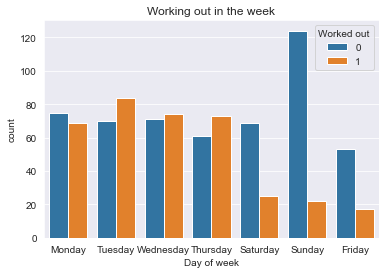

In [140]:
sns.countplot(x = 'Day of week', hue = 'Worked out', data = df_cleaned_days_week).set(title='Working out in the week')

[Text(0.5, 1.0, 'Working out in the week')]

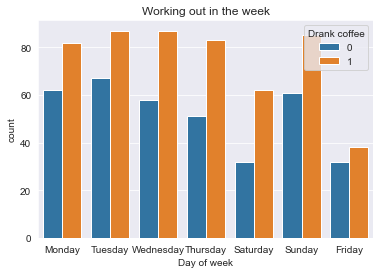

In [141]:
sns.countplot(x = 'Day of week', hue = 'Drank coffee', data = df_cleaned_days_week).set(title='Working out in the week')

[Text(0.5, 1.0, 'Drinking tea out in the week')]

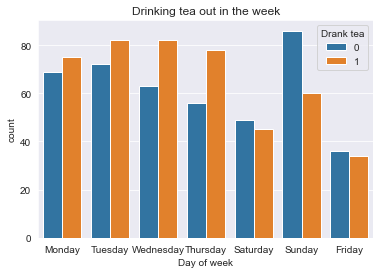

In [142]:
sns.countplot(x = 'Day of week', hue = 'Drank tea', data = df_cleaned_days_week).set(title='Drinking tea out in the week')

[Text(0.5, 1.0, 'Eating late in the week')]

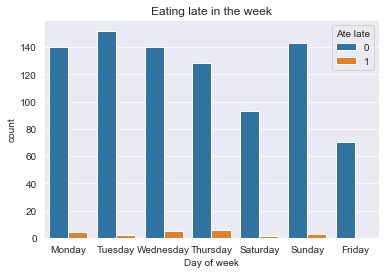

In [143]:
sns.countplot(x = 'Day of week', hue = 'Ate late', data = df_cleaned_days_week).set(title='Eating late in the week')

[Text(0.5, 1.0, 'Stressful day in the week')]

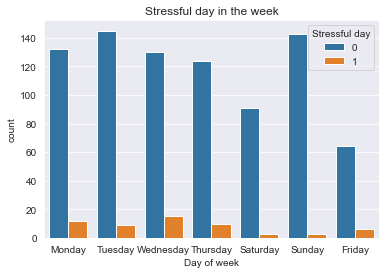

In [144]:
sns.countplot(x = 'Day of week', hue = 'Stressful day', data = df_cleaned_days_week).set(title='Stressful day in the week')

[Text(0.5, 1.0, 'Correlation matrix of the final data')]

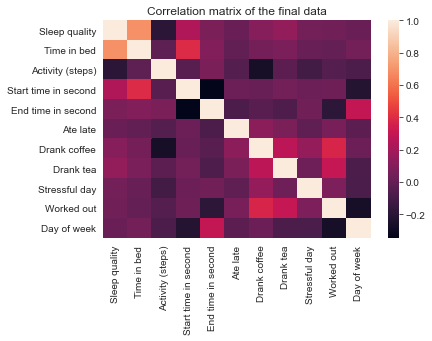

In [145]:
sns.heatmap(df_cleaned.corr()).set(title='Correlation matrix of the final data')

In [146]:
final_dataset=df_cleaned[['Start time in second','End time in second','Time in bed','Activity (steps)','Ate late','Worked out','Drank coffee','Drank tea','Stressful day','Day of week']]
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Start time in second  887 non-null    int64  
 1   End time in second    887 non-null    int64  
 2   Time in bed           887 non-null    float64
 3   Activity (steps)      887 non-null    int64  
 4   Ate late              887 non-null    int32  
 5   Worked out            887 non-null    int32  
 6   Drank coffee          887 non-null    int32  
 7   Drank tea             887 non-null    int32  
 8   Stressful day         887 non-null    int32  
 9   Day of week           887 non-null    int64  
dtypes: float64(1), int32(5), int64(4)
memory usage: 52.1 KB


In [147]:
y=df_cleaned['Sleep quality']
X=final_dataset.values
labels=['Start time in second','End time in second','Time in bed','Activity (steps)','Ate late','Worked out','Drank coffee','Drank tea','Stressful day']

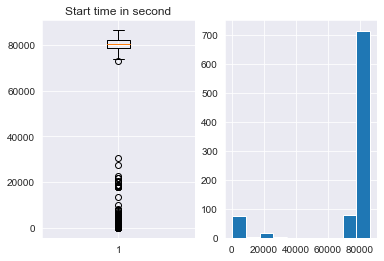

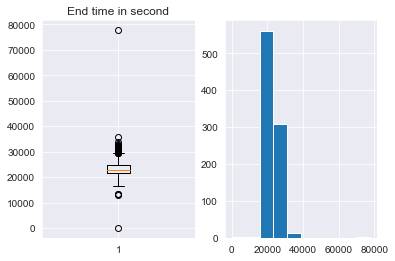

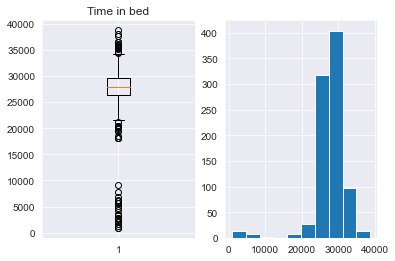

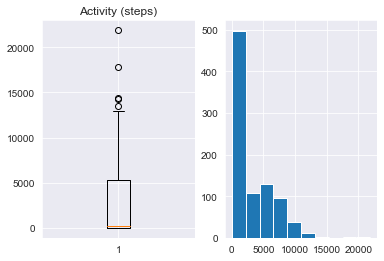

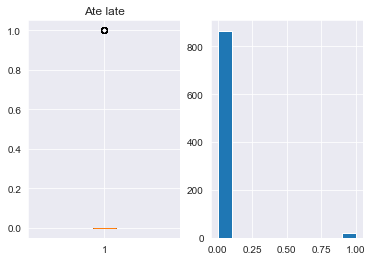

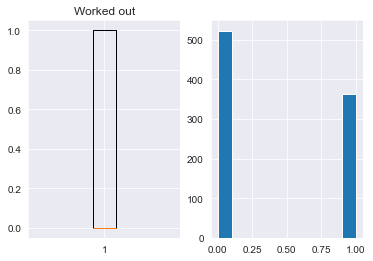

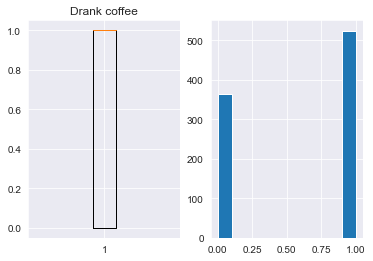

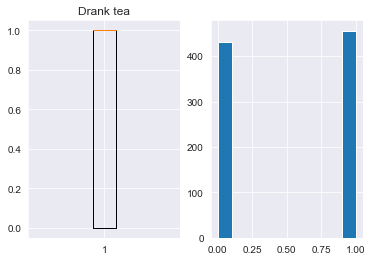

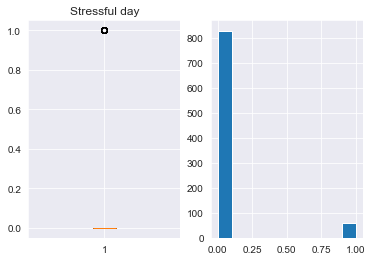

In [148]:
for i in range(len(labels)):
    feat=labels[i]
    fig, ax = plt.subplots(1,2)
    ax[0].boxplot(X[:,i])
    ax[1].hist(X[:,i])
    ax[0].set_title(feat)
    plt.show()

In [149]:
scaler = StandardScaler()

standardized_X = scaler.fit_transform(X)

print(X)

[[8.2669e+04 2.7013e+04 3.0744e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.6670e+04 7.7634e+04 9.6400e+02 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [8.1769e+04 2.6011e+04 3.0642e+04 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [7.7045e+04 2.2852e+04 3.2207e+04 ... 0.0000e+00 0.0000e+00 2.0000e+00]
 [7.7792e+04 2.4631e+04 3.3239e+04 ... 0.0000e+00 0.0000e+00 3.0000e+00]
 [8.2349e+04 2.8084e+04 3.2135e+04 ... 0.0000e+00 0.0000e+00 4.0000e+00]]


In [150]:
rules_dataset=final_dataset.copy()
rules_dataset['Sleep quality']=df_cleaned['Sleep quality']

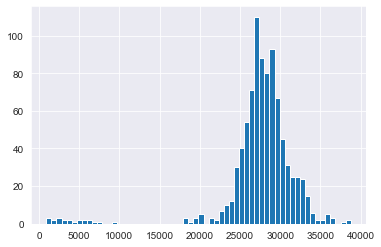

In [151]:
rul=rules_dataset['Time in bed'].hist(bins=60)

In [152]:
sep=10
for i in range(sep, 101, sep):
    rules_dataset["Sleep quality between "+str(i - sep)+"-"+str(i)] = ((rules_dataset["Sleep quality"] < i) & (rules_dataset["Sleep quality"] > (i-sep))).apply(lambda x: int(x))

<AxesSubplot:>

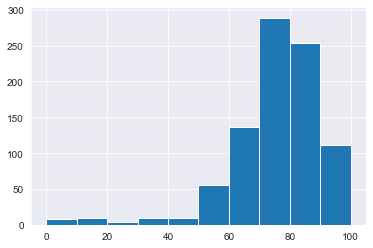

In [153]:
rules_dataset['Sleep quality'].hist(bins=sep)

In [154]:
rules_dataset=rules_dataset.drop(['Start time in second','End time in second','Time in bed','Activity (steps)','Sleep quality','Day of week'],axis=1)

In [155]:
er = apriori(rules_dataset, min_support = 0.1, use_colnames = True, verbose = 1)
df_ar = association_rules(er, metric = "confidence", min_threshold = 0.2)
df_ar

Processing 16 combinations | Sampling itemset size 4


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Drank coffee),(Worked out),0.590755,0.410372,0.333709,0.564885,1.376520,0.091280,1.355110
1,(Worked out),(Drank coffee),0.410372,0.590755,0.333709,0.813187,1.376520,0.091280,2.190663
2,(Drank tea),(Worked out),0.514092,0.410372,0.286359,0.557018,1.357348,0.075389,1.331041
3,(Worked out),(Drank tea),0.410372,0.514092,0.286359,0.697802,1.357348,0.075389,1.607912
4,(Sleep quality between 70-80),(Worked out),0.294250,0.410372,0.116122,0.394636,0.961654,-0.004630,0.974006
5,(Worked out),(Sleep quality between 70-80),0.410372,0.294250,0.116122,0.282967,0.961654,-0.004630,0.984264
6,(Sleep quality between 80-90),(Worked out),0.251409,0.410372,0.110485,0.439462,1.070887,0.007313,1.051896
7,(Worked out),(Sleep quality between 80-90),0.410372,0.251409,0.110485,0.269231,1.070887,0.007313,1.024387
8,(Drank coffee),(Drank tea),0.590755,0.514092,0.372041,0.629771,1.225015,0.068338,1.312451
9,(Drank tea),(Drank coffee),0.514092,0.590755,0.372041,0.723684,1.225015,0.068338,1.481076


In [156]:
##### Warnings, maybe not have ?
import warnings
warnings.filterwarnings('ignore')

In [157]:
#for testing the code: rm for testing our data
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

# CV, vers 2

#### One iteration:

In [158]:
x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

knn_model = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)
nb_model=GaussianNB().fit(x_train, y_train)
sv_model = SVC().fit(x_train, y_train)
dt_model=DecisionTreeClassifier().fit(x_train, y_train)

print(dt_model.score(x_test,y_test),
sv_model.score(x_test,y_test),
nb_model.score(x_test,y_test),
knn_model.score(x_test,y_test))


0.82 0.82 0.86 0.8


## Hyperparameterization

In [159]:
#decision trees

grid = {'criterion': ['gini', 'entropy', 'log_loss'],'splitter': ["best","random"],'min_samples_leaf':[1,2,3,4,5]}
classifier=DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5)
grid_search.fit(x_train, y_train)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test)) # why is this 0.78 but next cell is 0.04
print(grid_search.best_params_,grid_search.score(x_test,y_test)) # why so different? grid same always 

{'splitter': 'random', 'min_samples_leaf': 4, 'criterion': 'gini'} 0.7
{'criterion': 'gini', 'min_samples_leaf': 4, 'splitter': 'random'} 0.7


In [ ]:
#knn, takes unreasonable time? 
grid = {'n_neighbors' : np.random.randint(1,50,60), 
        'weights':['uniform','distance'], 
        'algorithm':['auto','ball_tree','kd_tree','brute'], 
        'leaf_size':[int(x) for x in np.linspace(start = 0, stop = 300, num=10)],
        'p':[1,2,3,4,5]}
classifier = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5)
grid_search.fit(x_train, y_train)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test)) # why is this 0.78 but next cell is 0.04
print(grid_search.best_params_,grid_search.score(x_test,y_test)) # why so different? grid same always 

In [ ]:
# SVC
# Error "X should be a square kernel matrix"? : ## Ok precomputed was the problem
grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'gamma': ['scale', 'auto'],'degree':[1,2,3,4]} # not inclded precomputed
classifier=SVC()
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5) 
grid_search.fit(x_train, y_train)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test)) # why is this 0.78 but next cell is 0.04
print(grid_search.best_params_,grid_search.score(x_test,y_test)) # why so different? grid same always 

# #Mini param test instead: ## Ok precomputed was the problem
# m0=SVC().fit(x_train, y_train)
# m1=SVC(kernel='poly',degree=2, coef0=1).fit(x_train, y_train)
# m2=SVC(kernel='rbf').fit(x_train, y_train)
# m3=SVC(kernel='sigmoid').fit(x_train, y_train)
# # m4=SVC(kernel='precomputed').fit(x_train, y_train)
# print(m0.score(x_test,y_test),m1.score(x_test,y_test),
#      m2.score(x_test,y_test),
#      m3.score(x_test,y_test)) #,
#     # m4.score(x_test,y_test))


In [ ]:
#NB
grid = {'var_smoothing': np.logspace(0,-9, num=100)}
classifier = GaussianNB()
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5)
grid_search.fit(x_train, y_train)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test)) # why is this 0.78 but next cell is 0.04
print(grid_search.best_params_,grid_search.score(x_test,y_test)) # why so different? grid same always 

## CV, before tuning

In [ ]:
accuracy_list_K_nearest_neighbor =[]
accuracy_list_naive_bayes =[]
accuracy_list_support_vector =[]
accuracy_list_decision_tree =[]



In [ ]:
for i in range(100):
    x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=np.random.uniform(low=0.2,high=0.35))
    
    """Fitting each model"""
    knn_model = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)
    nb_model=GaussianNB().fit(x_train, y_train)
    sv_model = SVC().fit(x_train, y_train)
    dt_model=DecisionTreeClassifier().fit(x_train, y_train)

    """Appending accuracy""" 
    accuracy_list_K_nearest_neighbor.append(knn_model.score(x_test,y_test))
    accuracy_list_naive_bayes.append(nb_model.score(x_test,y_test))
    accuracy_list_support_vector.append(sv_model.score(x_test,y_test))
    accuracy_list_decision_tree.append(dt_model.score(x_test,y_test))

accuracies=(accuracy_list_K_nearest_neighbor,
    accuracy_list_naive_bayes,
    accuracy_list_support_vector,
    accuracy_list_decision_tree)

print(f' accuracy for k-nn is: {np.mean(accuracy_list_K_nearest_neighbor)}')
print(f' accuracy for support vectors is: {np.mean(accuracy_list_support_vector)}')
print(f' accuracy for naive bayes is: {np.mean(accuracy_list_naive_bayes)}')
print(f' accuracy for decision trees is: {np.mean(accuracy_list_decision_tree)}')
print(f' mean accuracy is: {np.mean([np.mean(x) for x in accuracies])}')
print(f' best accuracy is: {max([np.mean(x) for x in accuracies])}')

## CV, after tuning

In [ ]:
accuracy_list_K_nearest_neighbor =[]
accuracy_list_naive_bayes =[]
accuracy_list_support_vector =[]
accuracy_list_decision_tree =[]

In [ ]:
for i in range(100):
    x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=np.random.uniform(low=0.2,high=0.35))
    
    """Fitting each model"""
    knn_model = KNeighborsClassifier(weights='uniform', p=5, n_neighbors= 34,
                                     leaf_size=100, algorithm='ball_tree').fit(x_train, y_train)
    nb_model=GaussianNB(var_smoothing= 0.12328467394420659).fit(x_train, y_train)
    sv_model = SVC(degree=1, gamma='auto', kernel= 'poly').fit(x_train, y_train)
    dt_model=DecisionTreeClassifier(criterion='gini', min_samples_leaf= 3, splitter='random').fit(x_train, y_train)

    """Appending accuracy""" 
    accuracy_list_K_nearest_neighbor.append(knn_model.score(x_test,y_test))
    accuracy_list_naive_bayes.append(nb_model.score(x_test,y_test))
    accuracy_list_support_vector.append(sv_model.score(x_test,y_test))
    accuracy_list_decision_tree.append(dt_model.score(x_test,y_test))
accuracies=(accuracy_list_K_nearest_neighbor,
    accuracy_list_naive_bayes,
    accuracy_list_support_vector,
    accuracy_list_decision_tree)

print(f' accuracy for k-nn is: {np.mean(accuracy_list_K_nearest_neighbor)}')
print(f' accuracy for support vectors is: {np.mean(accuracy_list_support_vector)}')
print(f' accuracy for naive bayes is: {np.mean(accuracy_list_naive_bayes)}')
print(f' accuracy for decision trees is: {np.mean(accuracy_list_decision_tree)}')
print(f' mean accuracy is: {np.mean([np.mean(x) for x in accuracies])}')
print(f' best accuracy is: {max([np.mean(x) for x in accuracies])}')